In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [3]:

# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [4]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

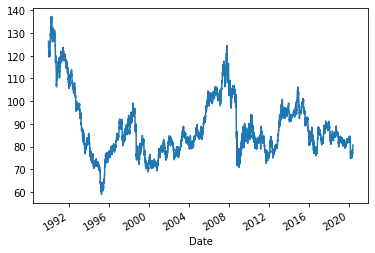

In [5]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot()

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Data looks non-stationary with upward and downward tremds. Expect to have varied mean, varicne and covariance across tiempariods. 
There is a cyclical pricing behaviour, high price is followed by shart drop , 1996 - 2016 recovery has followed by donward trajectory.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [6]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_df_noise, cad_jpy_df_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])


<AxesSubplot:xlabel='Date'>

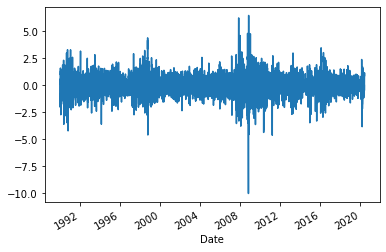

In [7]:
cad_jpy_df_noise.plot()

<AxesSubplot:xlabel='Date'>

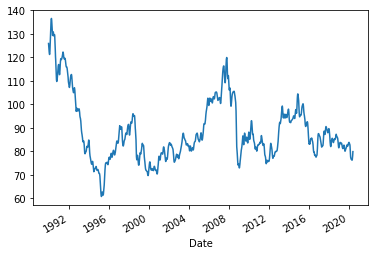

In [8]:
cad_jpy_df_trend.plot()

In [9]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
new_pd = pd.concat(
    [cad_jpy_df['Price'], cad_jpy_df_noise,cad_jpy_df_trend], axis="columns", join="inner"
)

new_pd = new_pd.rename(columns={
    "Price_cycle": "Noise",
    "Price_trend": "Trend"
}) 

new_pd.head()

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:title={'center':'Price vs. Trend'}, xlabel='Date'>

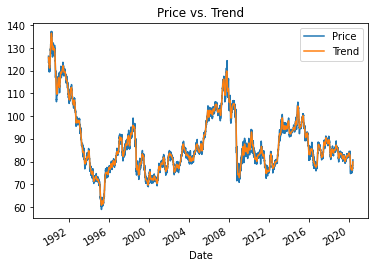

In [10]:
new_pd.drop(columns='Noise').plot(title='Price vs. Trend')


**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Price clearly folwes the trend with a minimal evidence of noise impacting

<AxesSubplot:xlabel='Date'>

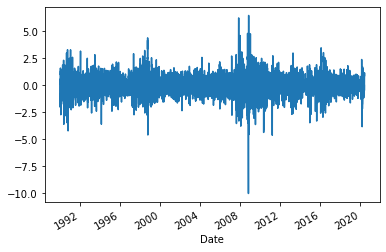

In [11]:
# Plot the Settle Noise
cad_jpy_df_noise.plot()

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [12]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [31]:
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA

In [32]:
# Estimate and ARMA model using statsmodels (use order=(2, 1))

ARMA_model = ARIMA(returns.values, order=(2,0,1))
ARMA_model

In [33]:
# Fit the model and assign it to a variable called results
results = ARMA_model.fit()

In [39]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -9752.310
Date:                Tue, 31 May 2022   AIC                          19514.620
Time:                        20:58:13   BIC                          19549.511
Sample:                             0   HQIC                         19526.568
                               - 7928                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.237      0.813      -0.021       0.016
ar.L1         -0.0152      3.499     -0.004      0.997      -6.873       6.843
ar.L2         -0.0018      0.107     -0.017      0.987      -0.212       0.209
ma.L1         -0.0153      3.499     -0.004      0.997      -6.874       6.844
sigma2         0.6855      0.006    122.678      0.000       0.675       0.696
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11578.41
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'Stock Return Forecast'}>

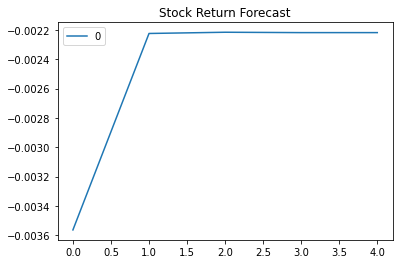

In [40]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)).plot(title="Stock Return Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** SINCE ARMA MODEL HAS BEEN DISCOUNTINUED I HAVE ONLU USED ARIMA MODEL, based on output p value is > 0.05 hence the model ant be used

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [18]:
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
MODEL = ARIMA(new_pd['Price'].values, order=(5,1,1))
MODEL

In [19]:
# Fit the model
# YOUR CODE HERE!
results = MODEL.fit()

In [20]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7929
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.898
Date:                Tue, 31 May 2022   AIC                          17505.796
Time:                        20:54:02   BIC                          17554.643
Sample:                             0   HQIC                         17522.523
                               - 7929                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4303      0.331      1.299      0.194      -0.219       1.080
ar.L2          0.0178      0.012      1.459      0.145      -0.006       0.042
ar.L3         -0.0118      0.009     -1.313      0.189      -0.029       0.006
ar.L4          0.0110      0.008      1.299      0.194      -0.006       0.028
ar.L5         -0.0191      0.007     -2.706      0.007      -0.033      -0.005
ma.L1         -0.4583      0.332     -1.381      0.167      -1.109       0.192
sigma2         0.5318      0.004    118.418      0.000       0.523       0.541
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9233.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'5 Day Forecast'}>

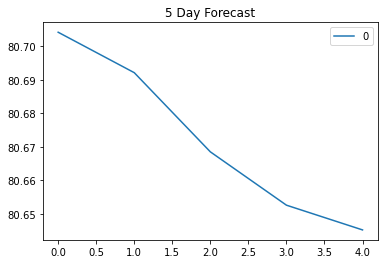

In [21]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
Price_Forecast = results.forecast(steps = 5)

pd.DataFrame(Price_Forecast).plot(title='5 Day Forecast')

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** YOUR ANSWER HERE

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [22]:
# Estimate a GARCH model:
from arch import arch_model

model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

In [23]:
# Fit the model
# YOUR CODE HERE!
results = model.fit(disp='off')

In [24]:
# Summarize the model results
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17828.0
Method:            Maximum Likelihood   BIC:                           17849.0
                                        No. Observations:                 7928
Date:                Tue, May 31 2022   Df Residuals:                     7928
Time:                        20:54:17   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.0734e-03  2.401e-03      3.779  1.574e-04 [4.368e-03,1.378e-02]
alpha[1]       0.0624  9.003e-03      6.936  4.036e-12 [4.480e-02,8.009e-02]
beta[1]        0.9243  1.110e-02     83.252      0.000     [  0.903,  0.946]
============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [25]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [26]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
# YOUR CODE HERE!

forecasts = results.forecast(start = last_day, horizon=forecast_horizon)


In [27]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566047,12.573736,12.581319,12.588797,12.596172


In [28]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566047
h.2,12.573736
h.3,12.581319
h.4,12.588797
h.5,12.596172


<AxesSubplot:>

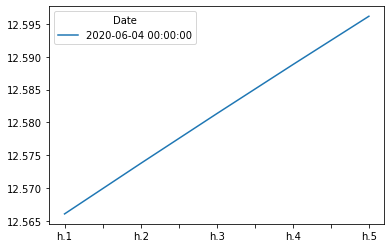

In [29]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** There is a very high volatility expected in near future, progresisvely growing in next 5 days.  

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * based on the results , I would not buy yen now as 1) ARIMA forecast price increase, yet model is not sta significant, L1 to L4 have p> 0.05.
    * GARCH shows an increas in volaitility over next 5 days, yet p value is outside of the tollerance. .  
    * HP model shows trend at historical lows and downard trajectory might be finished and form now we shoudl expect yen increase. To make model driven decissions I woudl run more ARIMAs to see which order is significant, same for GARCH. 

2. Is the risk of the yen expected to increase or decrease?
    * yes, based on GARCH 5 day linear increase. Angain question re p value and model fit. 

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * Not, I woudl run alternative ARIMAS to determine best order and model preformance. (5,1,1) my not be the best one to use considering p values. 